# Intrinsic model of coregionalization (IMC)
作者：Wei W Xing, ZhenjieLu<br/>
日期：2024-1-25<br/>
修改: 2024-2-22<br/>

当高斯过程的输入呈现某种网格规律的时候，可以使用该方法来进行建模，该方法的核心思想是将输入的网格规律进行分解，然后再进行建模，这样可以大大降低模型的复杂度，同时也可以提高模型的效率，这篇教程将会介绍如何使用该方法来进行建模，同时也会介绍如何使用该方法来进行预测，

这篇教程是基于torch开发的，同时涉及到画图以及加载数据等一些函数以及操作，所以在教程开始之前，先导入一些必须要的依赖库

首相介绍一些基本的数学知识

## 1.数学知识
网格规律的数据，可以看成是一个二维的数据，所以在介绍该方法之前，先介绍一些二维数据的基本知识。
例如，对于一个时间空间数据，可以看成是一个二维的数据，其中一个维度是时间，另一个维度是空间，这样的数据可以看成是一个二维的数据，对于二维的数据，可以使用矩阵来进行表示，如下所示：
$$
\begin{bmatrix}
y_{11} & y_{12} & \cdots & y_{1m} \\
y_{21} & y_{22} & \cdots & y_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
y_{n1} & y_{n2} & \cdots & y_{nm}
\end{bmatrix}
$$
其中，$y_{ij}$表示的是第$i$行第$j$列的数据，$m$表示总共有 $m$个空间传感器，$n$表示总共有$n$个时间点。
该$m$个空间传感器的空间位置使用一个输入矩阵来进行表示 $\mathbf{X} \in \mathbb{R}^{m \times 2}$，其中，每一行表示的是一个空间传感器的空间位置，第一列表示的是该空间传感器的横坐标，第二列表示的是该空间传感器的纵坐标; 同理，该$n$个时间点的时间位置使用一个输入矩阵来进行表示 $\mathbf{Z} \in \mathbb{R}^{n \times 1}$，其中，$n$表示的是数据的行数，每一行表示的是一个时间点的时间位置。


In [2]:
import torch
import torch.nn as nn
from scipy.io import loadmat
import matplotlib.pyplot as plt
JITTER = 1e-3


## 1.数据含义
首先，我们可以基于一个场景去理解，我们现在假设一个场景：需要预测某个地方的pm2.5浓度；我们需要一个建模输入输出的模型(在这个教程里面是STGP)，需要知道那个地方的高度，经纬度以及不同时间点的pm2.5浓度；这里的地方高度，经纬度以及时间就是模型的输入，对应的pm2.5的浓度就是模型的预测输出。很明显这是一个多维的问题，首先先让我们先导入数据~

In [3]:
data = loadmat('D:\iceLab\data_sample\data_v1_09_05_fill.mat')
time = data['time']  #time for the pm25 measurement data pm25
str = data['sTr']  #spatial coordinate [lat,long,elevation] for all sensors in SLC
pm25 = data['pm25']  #pm25 observed values for all sensors
str_daq = data['sTr_DAQ']  #spatial coordinate for daq sensors
pm25_daq = data['pm25_daq']  #reading from daq sensors

str = torch.tensor(str)
time = torch.tensor(time)
pm25 = torch.tensor(pm25)
str_daq = torch.tensor(str_daq)


## 2.核函数
在STGP中，我们采用的核函数是 SquaredExponential (SE) 平方指数核函数，核函数的计算公式如下：
$$k_{SE}(\mathbf{x}, \mathbf{x}') = \exp(-\frac{1}{2} \sum_{d=1}^D{ (\frac{x_d-x'_d}{l_d}})^2 )$$
其中，$l_d$是输入变量$x$的d维输入${x}_d$的长度系数（length scale）。$\mathbf{l}$ 控制着每个输入维度的贡献量，比如：$l_d$数值越大，则${x}_d$相比于其他维度在系统中的贡献越大；反之亦然。 <br />
需要注意的是$l_d$为正参数。所以如果我们直接将他们定义为torch中的参数torch.parameters，则在优化过程中有可能导致$l_d$被计算成负数。因此我们需要特别注意确保$l_d$在过程中为正数。一个简单的方法就是，用他们取log之后的值来定义，而使用的时候再将其转换为其指数值。这里因为我们的数据是多维的，因此SE_kernel为了适应维度也做了部分调整 <br />

现在我们可以定义核函数，其返回值为输入两组数据的一个核矩阵。

In [4]:
class SE_kernel(nn.Module):
    def __init__(self, length_scale=1.0):
        super().__init__()
        self.length_scale = nn.Parameter(torch.exp(torch.log(torch.tensor(length_scale))))

    def forward(self, X, X2):
        X = X / self.length_scale.expand(X.size(0), X.size(1))
        X2 = X2 / self.length_scale.expand(X2.size(0), X2.size(1))

        X_norm2 = torch.sum(X * X, dim=1).view(-1, 1)
        X2_norm2 = torch.sum(X2 * X2, dim=1).view(-1, 1)

        # compute effective distance
        K = -2.0 * X @ X2.t() + X_norm2.expand(X.size(0), X2.size(0)) + X2_norm2.t().expand(X.size(0), X2.size(0))
        K = torch.exp(-K) * 1.0
        return K

## 3.模型定义以及参数
在这个问题中，我们需要建模的输入很多，有经度、纬度、海拔高度以及时间；首先经纬度表示的是地理位置的信息，两者的相关性较高，因此不必要额外分开建模，因此模型需要建模经纬度，高度以及时间的相关性来根据先验，预测pm2.5的后验分布。经纬度，高度以及时间的相关性分别使用一个平方指数核建模

In [5]:
class stgp_demo(nn.Module):
    def __init__(self, latlong_length_scale=4300., elevation_length_scale=30., time_length_scale=0.25,
                 noise_variance=0.1, signal_variance=1.):
        super(stgp_demo, self).__init__()

        self.log_noise_variance = nn.Parameter(torch.log(torch.tensor(noise_variance)))
        self.log_signal_variance = nn.Parameter(torch.log(torch.tensor(signal_variance)))

        self.latlong_kernel = SE_kernel(latlong_length_scale)
        self.elevation_kernel = SE_kernel(elevation_length_scale)
        self.temporal_kernel = SE_kernel(time_length_scale)

## 4.跨模态建模背景知识
### 1.Kronecker积
一般而言，给定任意矩阵$ \mathbf{X} \in \mathbf{R}^{m \times n} $和$\mathbf{Y} \in \mathbf{R}^{p \times q}$，则矩阵$\mathbf{X}$ 和矩阵 $\mathbf{Y}$ 的Kronecker积为<br />
$$(\mathbf{X} \otimes \mathbf{Y})_{(i \cdot p) + k, (j \cdot q) + l} = X_{i, j} \cdot {Y}_{k, l}$$
或者
$$\mathbf{X} \otimes \mathbf{Y} = \begin{bmatrix} X_{1, 1} \cdot \mathbf{Y} & X_{1, 2} \cdot \mathbf{Y} & \cdots & X_{1, n} \cdot \mathbf{Y} \\ X_{2, 1} \cdot \mathbf{Y} & X_{2, 2} \cdot \mathbf{Y} & \cdots & X_{2, n} \cdot \mathbf{Y} \\ \vdots & \vdots & \ddots & \vdots \\ X_{m, 1} \cdot \mathbf{Y} & X_{m, 2} \cdot \mathbf{Y} & \cdots & X_{m, n} \cdot \mathbf{Y} \end{bmatrix}$$
具体知识可参考维基百科：https://en.wikipedia.org/wiki/Kronecker_product<br />
Kronecker积的代码实现如下：

In [6]:
def kronecker(A, B):
    AB = torch.einsum("ab,cd->acbd", A, B)
    AB = AB.view(A.size(0) * B.size(0), A.size(1) * B.size(1))
    return AB

### 2.特征分解
特征分解（Eigendecomposition），又称谱分解（Spectral decomposition）是将矩阵分解为由其特征值和特征向量表示的矩阵之积的方法。
若$A$是一个$N$ x $N$的方阵,且有$N$个线性独立的特征向量$q_i$(i=1,...,N),这样,$A$可以被分解为$$A = QΛQ^{-1}$$
其中$Q$是$N$×$N$方阵，且其第$i$列为$A$的特征向量$q_i$。$Λ$ 是对角矩阵，其对角线上的元素为对应的特征值，也即 $Λ_{ii}$=$\lambda_i$。

通过特征分解的方法可以求反(逆)矩阵
若矩阵$A$可被特征分解并特征值中不含零，则矩阵$A$为非奇异矩阵，且其逆矩阵可以由下式给出：
$$A^{-1} = QΛ^{-1}Q^{-1} $$
因为$Λ$为对角矩阵，其逆矩阵容易计算出：
$\left[\Lambda^{-1}\right]_{ii}=\frac{1}{\lambda_i}$

具体知识可以参考维基百科：https://zh.wikipedia.org/wiki/%E7%89%B9%E5%BE%81%E5%88%86%E8%A7%A3<br />

## 5.似然函数的负对数（negative log likelihood）
对于大部分回归问题，我们需要对已定义好的损失函数求最小值。那么在GP中，损失函数就是似然函数值的负对数。

因为我们需要对损失函数最小化，所以我们选择将似然函数取对数后再取相反数，并且由于似然函数值的对数有更为清晰的形式，并且不改变函数的单调性，所以对似然函数值取对数。高斯过程的似然函数的负对数形式为：
$$L=-\frac{1}{2}\mathbf{y}^T (\mathbf{K}+\sigma^2 \mathbf{I})^{-1}\mathbf{y}-\frac{1}{2}\log(|\mathbf{K}+\sigma^2 \mathbf{I}|)-\frac{n}{2}log(2\pi)$$
我们用$\mathbf{\Sigma}=\mathbf{K}+\sigma^2 \mathbf{I}$来代替核矩阵的逆，则损失函数可以写为：
$$nll=\frac{1}{2}\mathbf{y}^T\mathbf{\Sigma}^{-1}\mathbf{y}+\frac{1}{2}\log(|\mathbf{\Sigma}|)+\frac{n}{2}log(2\pi)$$
我们已经知道了高斯过程的似然函数的负对数的计算方法，但是STGP和单纯的GP不同，STGP建模多维输入而GP建模单维输入，因此在构建$\mathbf{\Sigma}$的过程中，STGP还需要经过特殊的处理：<br />
我们首先使用定义好的经纬度核函数、高度核函数以及时间核函数获得经纬度、高度以及时间的似然矩阵；由于经纬度以及高度同样属于空间信息，因此将两者的似然矩阵相乘获得空间似然矩阵，建模空间输入数据的相关性<br />
空间似然矩阵构建：$$K_{spatial} = K_{latlong} ⊙ K_{elevation}$$

我们的最终目的是要构建时空关系相关性的$\mathbf{\Sigma}$矩阵，由第三节给出的跨模态建模的背景知识，我们利用矩阵的特征分解，将时间似然矩阵以及空间似然矩阵进行特征分解，使用特征值$\lambda_s,\lambda_t$以及特征向量$v_s,v_t$去分别表示两个原始矩阵<br />
为了进行高维特征空间的变换，我们使用Kronecker积构建$\mathbf{\Sigma}$的特征值以及特征向量, 但是我们最终的目的是计算出似然函数的负对数，因此要构建$\mathbf{\Sigma}^{-1}$, 而$A^{-1} = QΛ^{-1}Q^{-1} $，因此需要计算出$Q$<br />
$$Q_{st} = v_s ⊗ v_t$$
因为$\left[\Lambda^{-1}\right]_{ii}=\frac{1}{\lambda_i}$，所以需要先构建$\lambda_i$再求逆，即：<br />
$$\lambda_i = \lambda_s ⊗ \lambda_t$$
然后将$\lambda_i$作为对角线元素构建对角矩阵$\Lambda^{-1}$<br />
最后$$\mathbf{\Sigma}^{-1} = Q_{st} \Lambda^{-1} Q_{st}^{-1} $$
这里为了方便实现$Q_{st}^{-1}$,使用了数学上特征分解的性质：矩阵分解出的特征矩阵是一个正交阵，正交阵的逆就是它的转置,即$Q^{T}=Q^{-1}\Leftrightarrow Q^{T}Q=QQ^{T}=I$，这样做可以避免矩阵的求逆运算<br />
构建出$\mathbf{\Sigma}^{-1}$后，根据nll的计算公式，可以写出代码~<br />
为了方便模型预测部分的计算，我们将$\mathbf{\Sigma}^{-1}y = \alpha$ 一同处理保存


In [7]:
def negative_log_likelihood(self, space_coordinates, time_coordinates, stData):
    latlong_K = self.latlong_kernel(space_coordinates[:, 0:2], space_coordinates[:, 0:2])
    elevation_K = self.elevation_kernel(space_coordinates[:, 2:3], space_coordinates[:, 2:3])

    spatial_K = latlong_K * elevation_K + torch.eye(latlong_K.size(0)) * JITTER
    temporal_K = self.temporal_kernel(time_coordinates, time_coordinates) + torch.eye(time_coordinates.size(0)) * JITTER

    # Matrix Eigendecomposition
    eigen_value_s, eigen_vector_s = torch.linalg.eigh(spatial_K, UPLO='L')
    eigen_value_t, eigen_vector_t = torch.linalg.eigh(temporal_K, UPLO='L')

    eigen_vector_st = kronecker(eigen_vector_t, eigen_vector_s)
    eigen_value_st = kronecker(eigen_value_t.view(-1, 1), eigen_value_s.view(-1, 1)).view(-1)

    #Build the overall sigma
    eigen_value_st_plus_noise_inverse = 1. / (eigen_value_st + torch.exp(self.log_noise_variance))

    #Option1:
    #sigma_inverse = eigen_vector_st @ eigen_value_st_plus_noise_inverse.diag_embed() @ eigen_vector_st.transpose(-2, -1)
    # self.K = eigen_vector_st @ eigen_value_st.diag_embed() @ eigen_vector_st.transpose(-2, -1)

    #Option2: Method to reduce calculation time(relate to MultiTaskGP_IMC_MathTutorial.md)
    Lambda_st = eigen_value_st_plus_noise_inverse.diag_embed()
    A = torch.flatten(eigen_vector_t.transpose(-2, -1) @ stData.transpose(-2, -1) @ eigen_vector_s).unsqueeze(-1)
    self.alpha = Lambda_st @ A
    self.Lambda_st = Lambda_st
    self.eigen_vector_st = eigen_vector_st

    nll = 0
    nll += 0.5 * (eigen_value_st + torch.exp(self.log_noise_variance)).log().sum()
    nll += 0.5 * (stData.transpose(-2, -1).reshape(1, -1) @ self.alpha).sum()
    #Option2:
    # nll += 0.5 * (A.transpose(-2, -1) @ self.alpha).sum()
    return nll

# 6. 模型训练
当损失函数，也就是似然函数的负对数定义好之后，我们可以很简单地通过调用优化器来最小化损失函数值训练模型，这里我们使用Adam优化器。

In [8]:
def train_stgp(model, train_space_coordinates, train_time_coordinates, train_stData, lr=0.1, epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.LBFGS(modelparameters(), lr=lr)
    for i in range(epochs):
        optimizer.zero_grad()
        loss = model.negative_log_likelihood(train_space_coordinates, train_time_coordinates, train_stData)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print('Epoch: {}, Loss: {}'.format(i, loss.item()))


## 7. 模型预测
当超参数优化完毕之后，我们可以根据如下GP预测的公式对预测后验分布进行计算：
\begin{aligned}
&\mu=\mathbf{k}^* \Sigma^{-1} \mathbf{y}\\
&s^2=\mathbf{k}_{**}- (\mathbf{k}^*)^T \mathbf{\Sigma}^{-1} \mathbf{k}^* + {1}/{\beta}\\
\end{aligned}
同样，这里的$k^{*}$需要使用与求复对数似然那样的方法去拿到时空似然矩阵；对于方差的计算，这里使用了一个更加快捷的方式计算

In [9]:
def forward(self, train_space_coordinates, train_time_coordinates, test_space_coordinates, test_time_coordinates):
    test_latlong_K = self.latlong_kernel(test_space_coordinates[:, 0:2], train_space_coordinates[:, 0:2])
    test_elevation_K = self.elevation_kernel(test_space_coordinates[:, 2:3], train_space_coordinates[:, 2:3])
    test_spatial_K = test_latlong_K * test_elevation_K
    test_temporal_K = self.temporal_kernel(test_time_coordinates, train_time_coordinates)
    test_st_K = kronecker(test_temporal_K, test_spatial_K)
    yPred = test_st_K @ self.alpha
    sigma_inverse = self.eigen_vector_st @ self.Lambda_st @ self.eigen_vector_st.transpose(-2, -1)
    diag_term = (test_st_K @ sigma_inverse @ test_st_K.t()).diag()
    yVar = self.log_signal_variance.exp() - diag_term

    #Option2: a faster way
    # sigma_inverse = self.eigen_vector_st @ self.Lambda_st @ self.eigen_vector_st.transpose(-2, -1)
    # K_space_star2 = self.latlong_kernel(test_space_coordinates[:, 0:2], test_space_coordinates[:, 0:2])
    # K_time_star2 = self.temporal_kernel(test_time_coordinates, test_time_coordinates)
    # K_space_time_star2 = kronecker(K_time_star2, K_space_star2)
    # yVar = K_space_time_star2.diag() - (test_st_K @ sigma_inverse @ test_st_K.t()).diag()

    yPred = yPred.view(test_time_coordinates.size(0), test_space_coordinates.size(0)).transpose(-2, -1)
    yVar = yVar.view(test_time_coordinates.size(0), test_space_coordinates.size(0)).transpose(-2, -1)

    return yPred, yVar

完整的STGP类定义如下：

In [10]:
class stgp(nn.Module):
    def __init__(self, latlong_length_scale=4300., elevation_length_scale=30., time_length_scale=0.25,
                 noise_variance=0.1, signal_variance=1.):
        super(stgp, self).__init__()

        self.log_noise_variance = nn.Parameter(torch.log(torch.tensor(noise_variance)))
        self.log_signal_variance = nn.Parameter(torch.log(torch.tensor(signal_variance)))

        self.latlong_kernel = SE_kernel(length_scale=latlong_length_scale)
        self.elevation_kernel = SE_kernel(length_scale=elevation_length_scale)
        self.temporal_kernel = SE_kernel(length_scale=time_length_scale)

    def negative_log_likelihood(self, space_coordinates, time_coordinates, stData):
        latlong_K = self.latlong_kernel(space_coordinates[:, 0:2], space_coordinates[:, 0:2])
        elevation_K = self.elevation_kernel(space_coordinates[:, 2:3], space_coordinates[:, 2:3])

        spatial_K = latlong_K * elevation_K + torch.eye(latlong_K.size(0)) * JITTER
        temporal_K = self.temporal_kernel(time_coordinates, time_coordinates) + torch.eye(
            time_coordinates.size(0)) * JITTER

        # Matrix Eigendecomposition
        eigen_value_s, eigen_vector_s = torch.linalg.eigh(spatial_K, UPLO='L')
        eigen_value_t, eigen_vector_t = torch.linalg.eigh(temporal_K, UPLO='L')

        eigen_vector_st = kronecker(eigen_vector_t, eigen_vector_s)
        eigen_value_st = kronecker(eigen_value_t.view(-1, 1), eigen_value_s.view(-1, 1)).view(-1)
        eigen_value_st_plus_noise_inverse = 1. / (eigen_value_st + torch.exp(self.log_noise_variance))

        Lambda_st = eigen_value_st_plus_noise_inverse.diag_embed()
        A = torch.flatten(eigen_vector_t.transpose(-2, -1) @ stData.transpose(-2, -1) @ eigen_vector_s).unsqueeze(-1)
        self.alpha = Lambda_st @ A
        self.Lambda_st = Lambda_st
        self.eigen_vector_st = eigen_vector_st

        nll = 0
        nll += 0.5 * (eigen_value_st + torch.exp(self.log_noise_variance)).log().sum()
        nll += 0.5 * (A.transpose(-2, -1) @ self.alpha).sum()
        return nll

    def forward(self, train_space_coordinates, train_time_coordinates, test_space_coordinates, test_time_coordinates):
        test_latlong_K = self.latlong_kernel(test_space_coordinates[:, 0:2], train_space_coordinates[:, 0:2])
        test_elevation_K = self.elevation_kernel(test_space_coordinates[:, 2:3], train_space_coordinates[:, 2:3])
        test_spatial_K = test_latlong_K * test_elevation_K
        test_temporal_K = self.temporal_kernel(test_time_coordinates, train_time_coordinates)
        test_st_K = kronecker(test_temporal_K, test_spatial_K)
        yPred = test_st_K @ self.eigen_vector_st @ self.alpha

        sigma_inverse = self.eigen_vector_st @ self.Lambda_st @ self.eigen_vector_st.transpose(-2, -1)

        diag_term = (test_st_K @ sigma_inverse @ test_st_K.t()).diag()
        yVar = self.log_signal_variance.exp() - diag_term

        yPred = yPred.view(test_time_coordinates.size(0), test_space_coordinates.size(0)).transpose(-2, -1)
        yVar = yVar.view(test_time_coordinates.size(0), test_space_coordinates.size(0)).transpose(-2, -1)

        return yPred, yVar

## 8.测试与验证
最后，我们实例化模型并对其进行训练以及预测，并将结果可视化

Epoch: 0, Loss: 2043894.656893604
Epoch: 10, Loss: 761452.3542491442
Epoch: 20, Loss: 481496.2283957148
Epoch: 30, Loss: 336564.8269648087
Epoch: 40, Loss: 254849.65093105083
Epoch: 50, Loss: 204419.07517628078
Epoch: 60, Loss: 170360.24407072223
Epoch: 70, Loss: 145665.87523259083
Epoch: 80, Loss: 126849.2458588182
Epoch: 90, Loss: 112036.5425486945


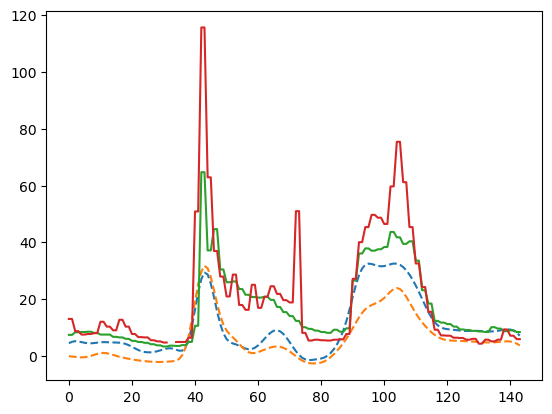

In [12]:
model = stgp()
train_stgp(model, str, time, pm25, lr=0.1, epochs=100)
with torch.no_grad():
    yPred, yVar = model(str, time, str_daq, time)

plt.plot(yPred.numpy().T, '--')  #show the predictions at the daq locations
plt.plot(pm25_daq.T, '-')  #show the daq observations
plt.show()